In [1]:
import sys
import pandas as pd
import numpy as np
from numpy import log
from pandas import Series

from statsmodels.tsa.stattools import adfuller
#from pandas.core import datetools

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [5]:
print(sys.version)

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]


# what is time series analytics?

- Time series data is data that is measured at equally-spaced intervals. Think of a sensor that takes measurements every minute.

- Time series analysis attempts to understand the past and predict the future

- Examples
    - Price of stock over successive days
    - Sizes of packets over network
    - Sizes of queries to a database system
    - Number of active VMs in a cloud

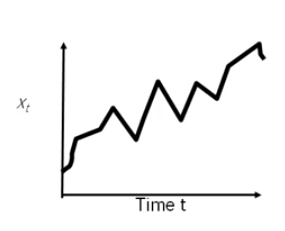

# Conceptual topics

- Trends
- Seasonality
- Cyclical movements
- Unexpected variations

- ** Stationarity **


## (1) Trend
Trend, as its name suggests, is the overall direction of the data. Trends indicate a slow change in the behavior of a variable in time, in its average over a long period.

Although consecutive measurements may increase or decrease on an opposed direction, the overall behavior persists over time. An example of this is climate; in the Northern Hemisphere, temperatures might decrease by several degrees in May from one day to the next day, but the overall behavior is warming towards the summer.

### Trend - example 1 - Detect trend 

__Flotation cell__
Description:	Data from a zinc-lead flotation cell measured on 5 variables; recorded from the PLCs.

Data source:	Actual data from a mining company.

Data shape:	2922 rows and 5 columns

In [2]:
location = r'E:\MYLEARN\2-ANALYTICS-DataScience\datasets\flotation-cell.csv'

In [6]:
df_fcdata  = pd.read_csv(location, index_col=0)

In [7]:
df_fcdata.shape

(2922, 5)

In [8]:
df_fcdata.head()

,Feed rate,Upstream pH,CuSO4 added,Pulp level,Air flow rate
Date and time,,,,,
15/12/2004 19:57:01,341.049347,10.820513,7.995605,24.443470,2.802198
15/12/2004 19:57:31,274.270782,10.827351,7.786569,27.819294,2.798535
15/12/2004 19:58:01,334.836761,10.854701,7.655922,30.335533,2.805861
15/12/2004 19:58:32,323.605927,10.885470,7.838828,30.663738,2.802198
15/12/2004 19:59:03,322.341309,10.851282,7.995605,30.288647,2.805861


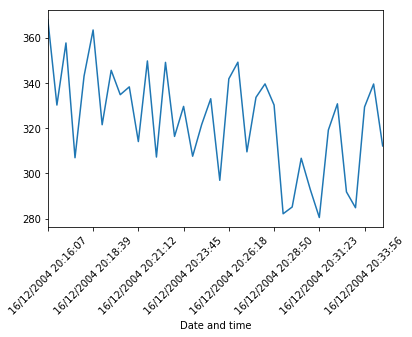

In [10]:
selected = df_fcdata.loc[(df_fcdata.index > '16/12/2004 20:16:00') & 
                         (df_fcdata.index < '16/12/2004 20:35:00'),
                         'Feed rate']

selected.plot(rot=45);


- we will be using a __polynomial fitting function, polyfit()__ to find the best adjusting first degree polynomial and its fitting error. 

- A first degree polynomial has 2 parameters, that we can call the _slope and the offset_. 

- If the slope is different from zero, then there is a trend in the data

- the residuals (that gives us a measure of the fitting error and that we will convert into the Normalized Mean Squared Error (NRMSE), that gives us a measurement of the error between 0 and 1)

In [11]:
type(selected)

pandas.core.series.Series

In [12]:
len(selected.index)

38

In [13]:
range(len(selected.index))

range(0, 38)

In [14]:
coefficients, residuals, _, _, _ = np.polyfit(range(len(selected.index)),
                                              selected,
                                              1,
                                              full=True)

In [15]:
coefficients

array([ -1.074735  , 343.38421087])

In [16]:
residuals

array([14669.19651345])

In [17]:
mse = residuals[0]/(len(selected.index))

nrmse = np.sqrt(mse)/(selected.max() - selected.min())

print('Slope ' + str(coefficients[0]))
print('NRMSE: ' + str(nrmse))

Slope -1.0747349976267206
NRMSE: 0.2247756782437052


- We can see that a negative trend is detected, of about -1.73 units of the Feed rate per time interval (in this dataset, the time interval is 30 seconds), 

- with an error of about 27.4%. 

We can now draw the trend line. Remember that the trend line is a polynomial in the Ax+B form:

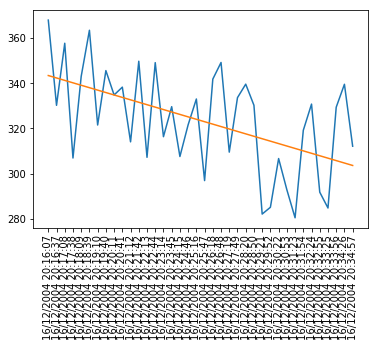

In [18]:
plt.xticks(rotation=90)
plt.plot(selected)
plt.plot([coefficients[0]*x + coefficients[1] for x in range(len(selected))]);


In [19]:
# define a function to check trend and plot

def detect_trend (X_df):
    coefficients, residuals, _, _, _ = np.polyfit(range(len(X_df)),
                                                              X_df,
                                                              1,
                                                              full=True)

    mse = residuals[0]/(len(X_df))
    nrmse = np.sqrt(mse)/(X_df.max() - X_df.min())

    print('Slope ' + str(coefficients[0]))
    print('NRMSE: ' + str(nrmse))

    plt.xticks(rotation=90)
    plt.plot(X_df)
    plt.plot([coefficients[0]*x + coefficients[1] for x in range(len(X_df))]);

### Trend - example 2 - detrend using scipy

In [20]:
from scipy.signal import detrend
from scipy import arange

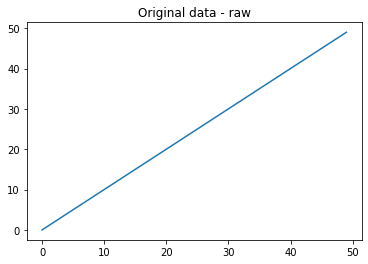

In [25]:
data = arange(0, 50)
plt.title("Original data - raw")
plt.plot(data);

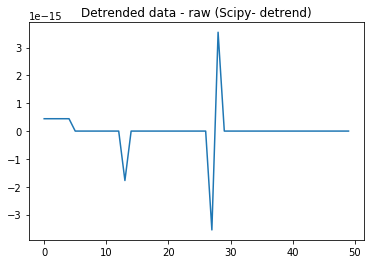

In [26]:
detrend_scipy_data = detrend(data)

plt.title("Detrended data - raw (Scipy- detrend)")
plt.plot(detrend_scipy_data)

Slope -2.4950030037194375e-18
NRMSE: 0.10776541817365003


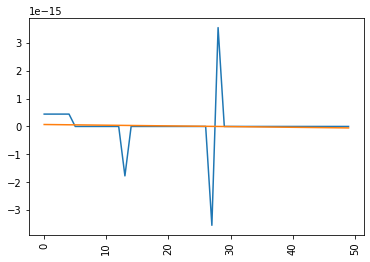

In [27]:
# check for trend
detect_trend(detrend_scipy_data)

### Trend - example 3 - detect and detrend (scipy and differencing)

In [21]:
location = r'E:\MYLEARN\2-ANALYTICS-DataScience\datasets\sales-of-shampoo-over-a-three-year.csv'

In [23]:
df_sales_data  = pd.read_csv(location, index_col=0)

In [24]:
print(df_sales_data.shape)
df_sales_data.head()

(36, 1)


,Sales of shampoo over a three year period
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


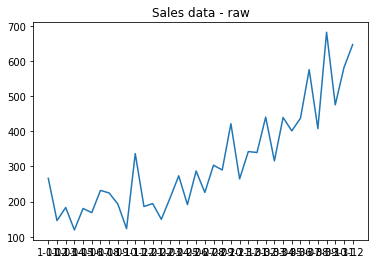

In [25]:
plt.title("Sales data - raw")
plt.plot(df_sales_data);

Slope [12.07907336]
NRMSE: Sales of shampoo over a three year period    0.135584
dtype: float64


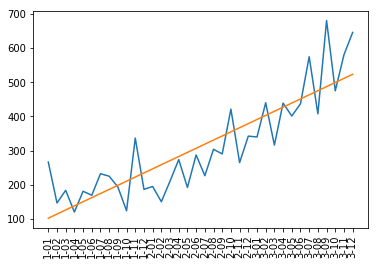

In [26]:
# check if the trend is there 
detect_trend(df_sales_data)

In [28]:
# Method 1 : detrend - using scipy
detrend_scipy_sales_data = detrend(df_sales_data)


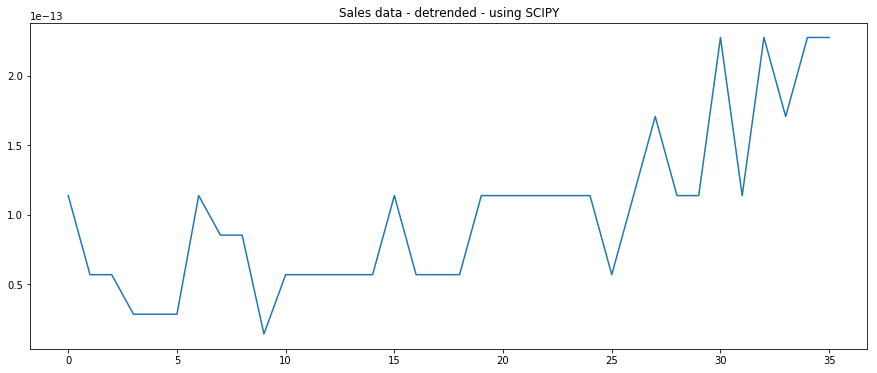

In [29]:
plt.title("Sales data - detrended - using SCIPY")
plt.plot(detrend_scipy_sales_data);

Slope [4.18644098e-15]
NRMSE: 0.17970706152317614


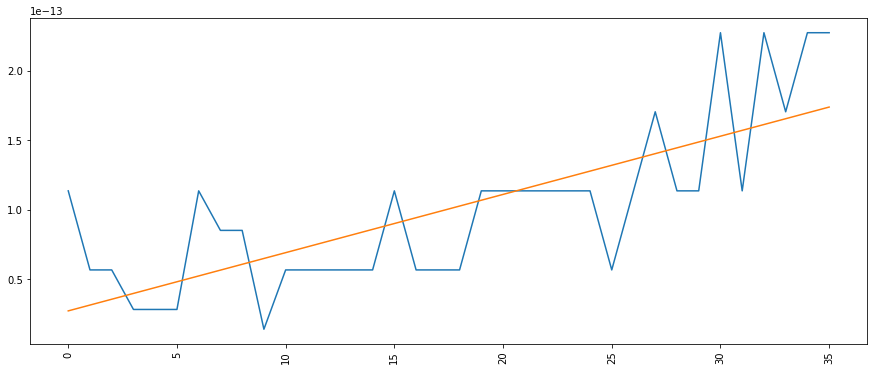

In [30]:
# check if the trend is there 
detect_trend(detrend_scipy_sales_data)

In [27]:
# Method 2 : detrend - differencing
X    = df_sales_data.values

diff = list()

for i in range(1, len(X)):
    value = X[i] - X[i - 1]
    diff.append(value)

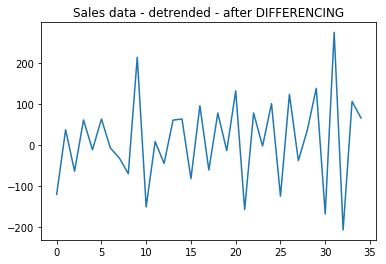

In [28]:
plt.title("Sales data - detrended - after DIFFERENCING")
plt.plot(diff);

In [29]:
diff = np.array(diff)

Slope [1.45058824]
NRMSE: 0.221758405166822


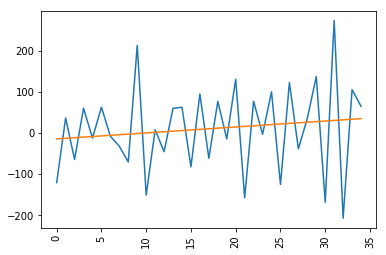

In [30]:
# check if the trend is there 
detect_trend(diff)

### Trend - example 4 - detrend by model fitting

In [31]:
from sklearn.linear_model import LinearRegression

In [32]:
location = r'E:\MYLEARN\2-ANALYTICS-DataScience\datasets\sales-of-shampoo-over-a-three-year.csv'

In [33]:
df_sales_data  = pd.read_csv(location, index_col=0)

In [34]:
print(df_sales_data.shape)
df_sales_data.head()

(36, 1)


,Sales of shampoo over a three year period
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


In [35]:
X = [i for i in range(0, len(df_sales_data))]
X = np.reshape(X, (len(X), 1))
X

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35]])

In [36]:
y = df_sales_data.values

In [37]:
# instatiate the linear reg model
model = LinearRegression()

In [38]:
# fit the data
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [39]:
# calculate predicted values
y_pred = model.predict(X)

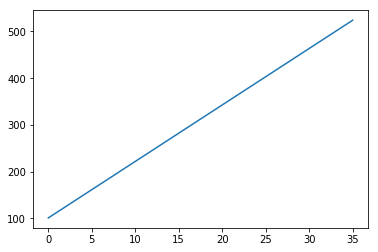

In [40]:
# plot the trend
plt.plot(y_pred);

Slope [-7.47716008e-16]
NRMSE: 0.25179423797379263


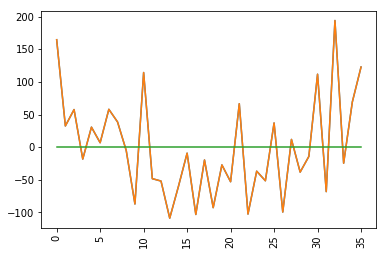

In [41]:
# detrend
detrended = [y[i] - y_pred[i] for i in range(0, len(df_sales_data))]

# plot detrended
plt.plot(detrended)

# check if the trend is there 
detect_trend(np.array(detrended))

## (2) Seasonality

types of seasonality; for example:

    Time of Day.
    Daily.
    Weekly.
    Monthly.
    Yearly.

The simplest approach to determining if there is an aspect of seasonality is to plot and review the data

In [36]:
# using plots to check seasonality

In [42]:
location = r'E:\MYLEARN\2-ANALYTICS-DataScience\datasets\multiTimeline.csv'

In [43]:
df = pd.read_csv(location)
df.head()

,month,diet,gym,finance
0,2004-01,100,31,48
1,2004-02,75,26,49
2,2004-03,67,24,47
3,2004-04,70,22,48
4,2004-05,72,22,43


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
month      168 non-null object
diet       168 non-null int64
gym        168 non-null int64
finance    168 non-null int64
dtypes: int64(3), object(1)
memory usage: 5.3+ KB


In [45]:
df.month = pd.to_datetime(df.month)
df.set_index('month', inplace=True)
df.head()

,diet,gym,finance
month,,,
2004-01-01,100,31,48
2004-02-01,75,26,49
2004-03-01,67,24,47
2004-04-01,70,22,48
2004-05-01,72,22,43


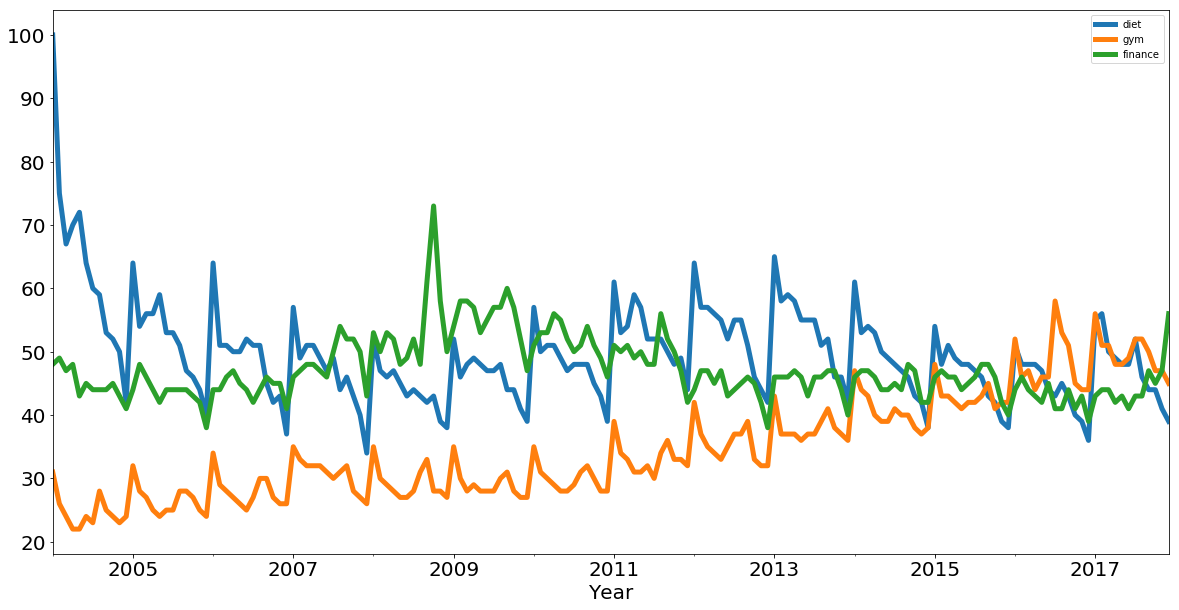

In [46]:
df.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

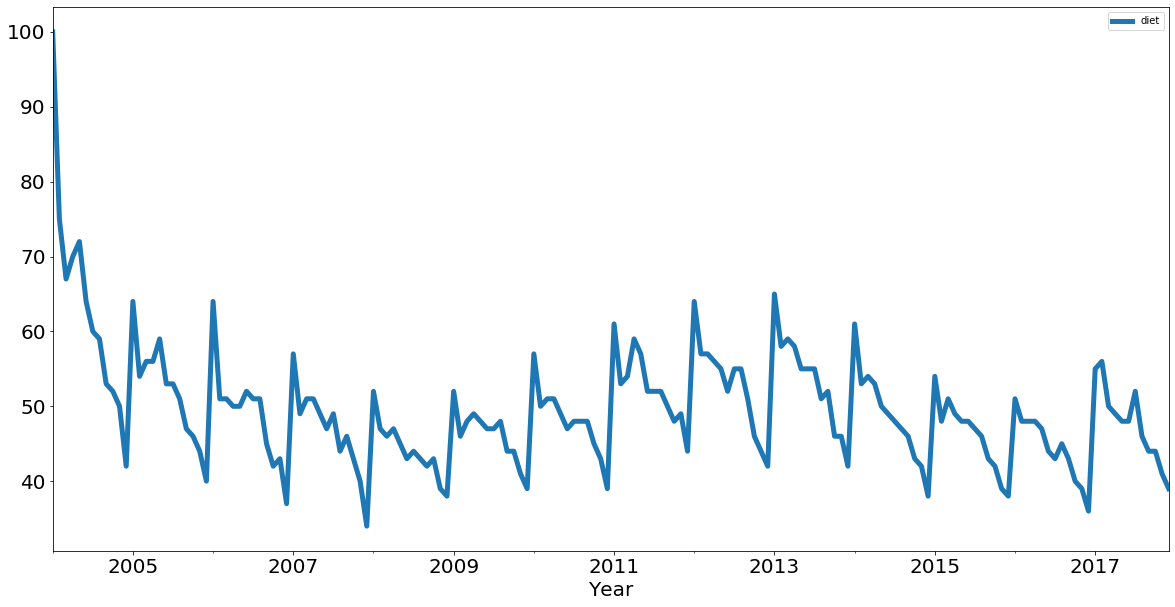

In [45]:
# plot the 'diet' column by itself as a time series:

df[['diet']].plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

Note: 
- there is __seasonality__: each January, there's a big jump. 

- Also, there seems to be a __trend__: it seems to go slightly up, then down, back up and then back down. 

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence.

# (3) White NOISE 

- how to detect

In [51]:
from random import gauss
from random import seed
from pandas import Series
from pandas.plotting import autocorrelation_plot

# seed random number generator
seed(1)

# create white noise series
series = [gauss(0.0, 1.0) for i in range(1000)]
series = Series(series)


In [52]:
# summary stats
print(series.describe())

count    1000.000000
mean       -0.013222
std         1.003685
min        -2.961214
25%        -0.684192
50%        -0.010934
75%         0.703915
max         2.737260
dtype: float64


We can see that the mean is nearly 0.0 and the standard deviation is nearly 1.0. Some variance is expected given the small size of the sample.

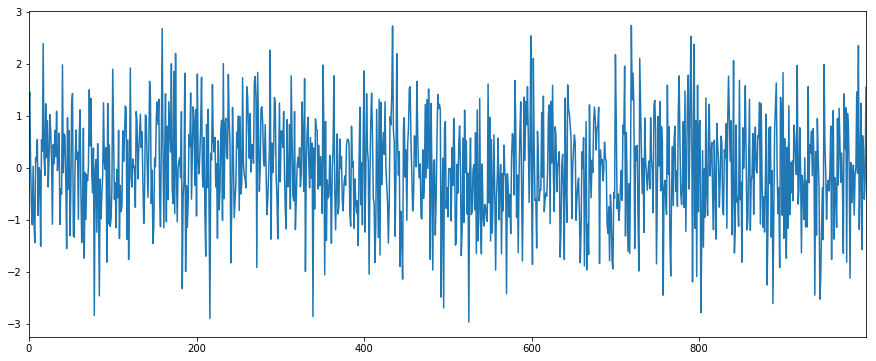

In [6]:
# line plot
series.plot();


We can see that it does appear that the series is random.

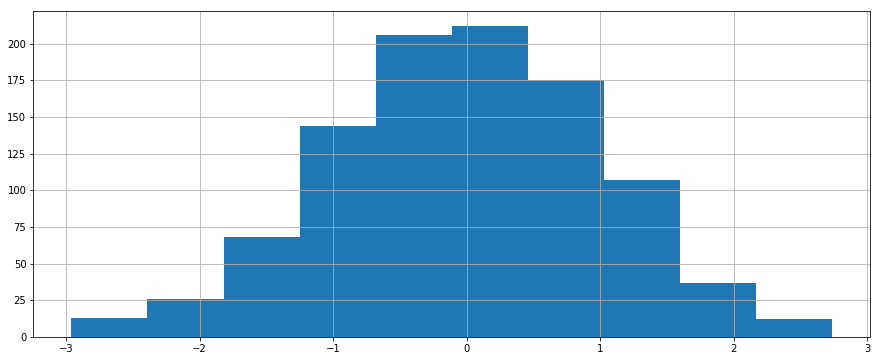

In [7]:
series.hist();

the histogram shows the bell-curve shape.

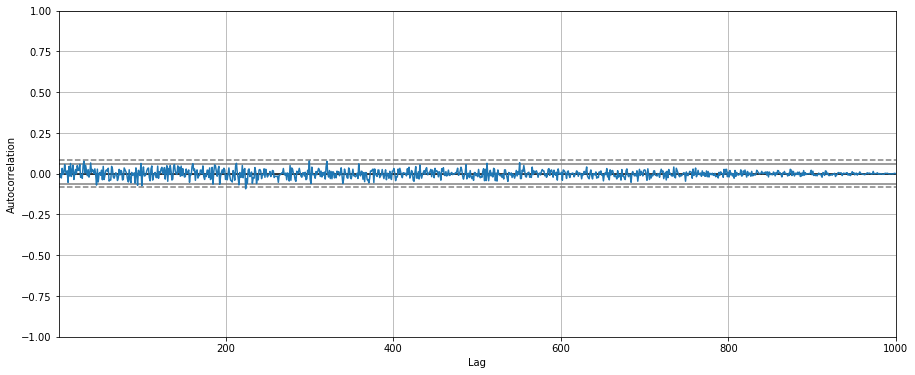

In [11]:
# autocorrelation
autocorrelation_plot(series);


# (4) Random Walk

#### Example 1

In [12]:
# Probability to move up or down 
prob = [0.05, 0.95]   


In [13]:
# statically defining the starting position 
start = 2  
positions = [start] 

In [14]:
# creating the random points 
rr = np.random.random(1000) 


In [19]:
downp = rr < prob[0] 
upp   = rr > prob[1] 


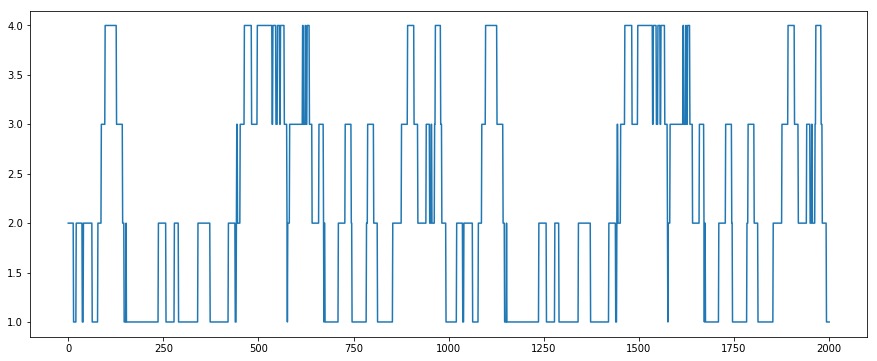

In [21]:
for idownp, iupp in zip(downp, upp): 
    down = idownp and positions[-1] > 1
    up = iupp and positions[-1] < 4
    positions.append(positions[-1] - down + up) 
  
# plotting down the graph of the random walk in 1D 
plt.plot(positions) ;



#### Example 2

In [24]:
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

#### Random walk in 1-D :

We start at origin(y=0) and choose a step to move for each successive step with equal probability. Starting point is shown in red and end point is shown in black. A cumulative sum is plotted in the plot below which shows path followed by a body in 1D over 10k steps.

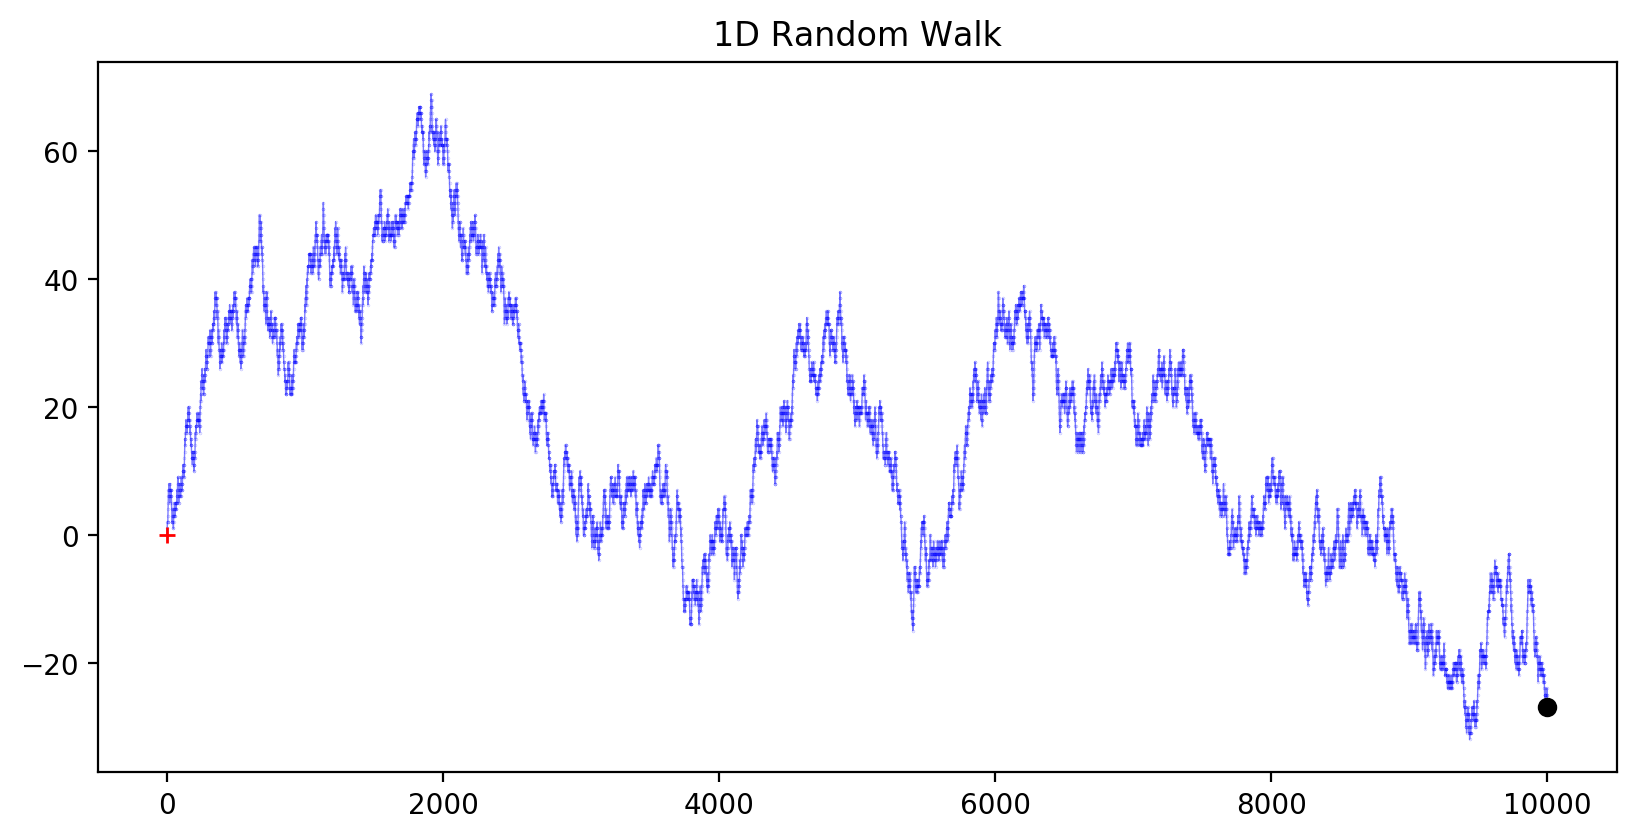

In [27]:
# Define parameters for the walk
dims     = 1
step_n   = 10000
step_set = [-1, 0, 1]

origin = np.zeros((1, dims))

# Simulate steps in 1D
step_shape = (step_n, dims)
steps      = np.random.choice(a=step_set, size=step_shape)
path       = np.concatenate([origin, steps]).cumsum(0)

start = path[:1]
stop  = path[-1:]

# Plot the path
fig = plt.figure(figsize=(8,4),dpi=200)
ax  = fig.add_subplot(111)

ax.scatter(np.arange(step_n+1), path, c='blue', alpha=0.25, s=0.05);
ax.plot(path,c='blue', alpha=0.5, lw=0.5);
ax.plot(0, start, c='red', marker='+')
ax.plot(step_n, stop, c='black', marker='o')

plt.title('1D Random Walk')
plt.tight_layout(pad=0)
#plt.savefig(‘plots/random_walk_1d.png’,dpi=250);

#### Random walk in 2-D :

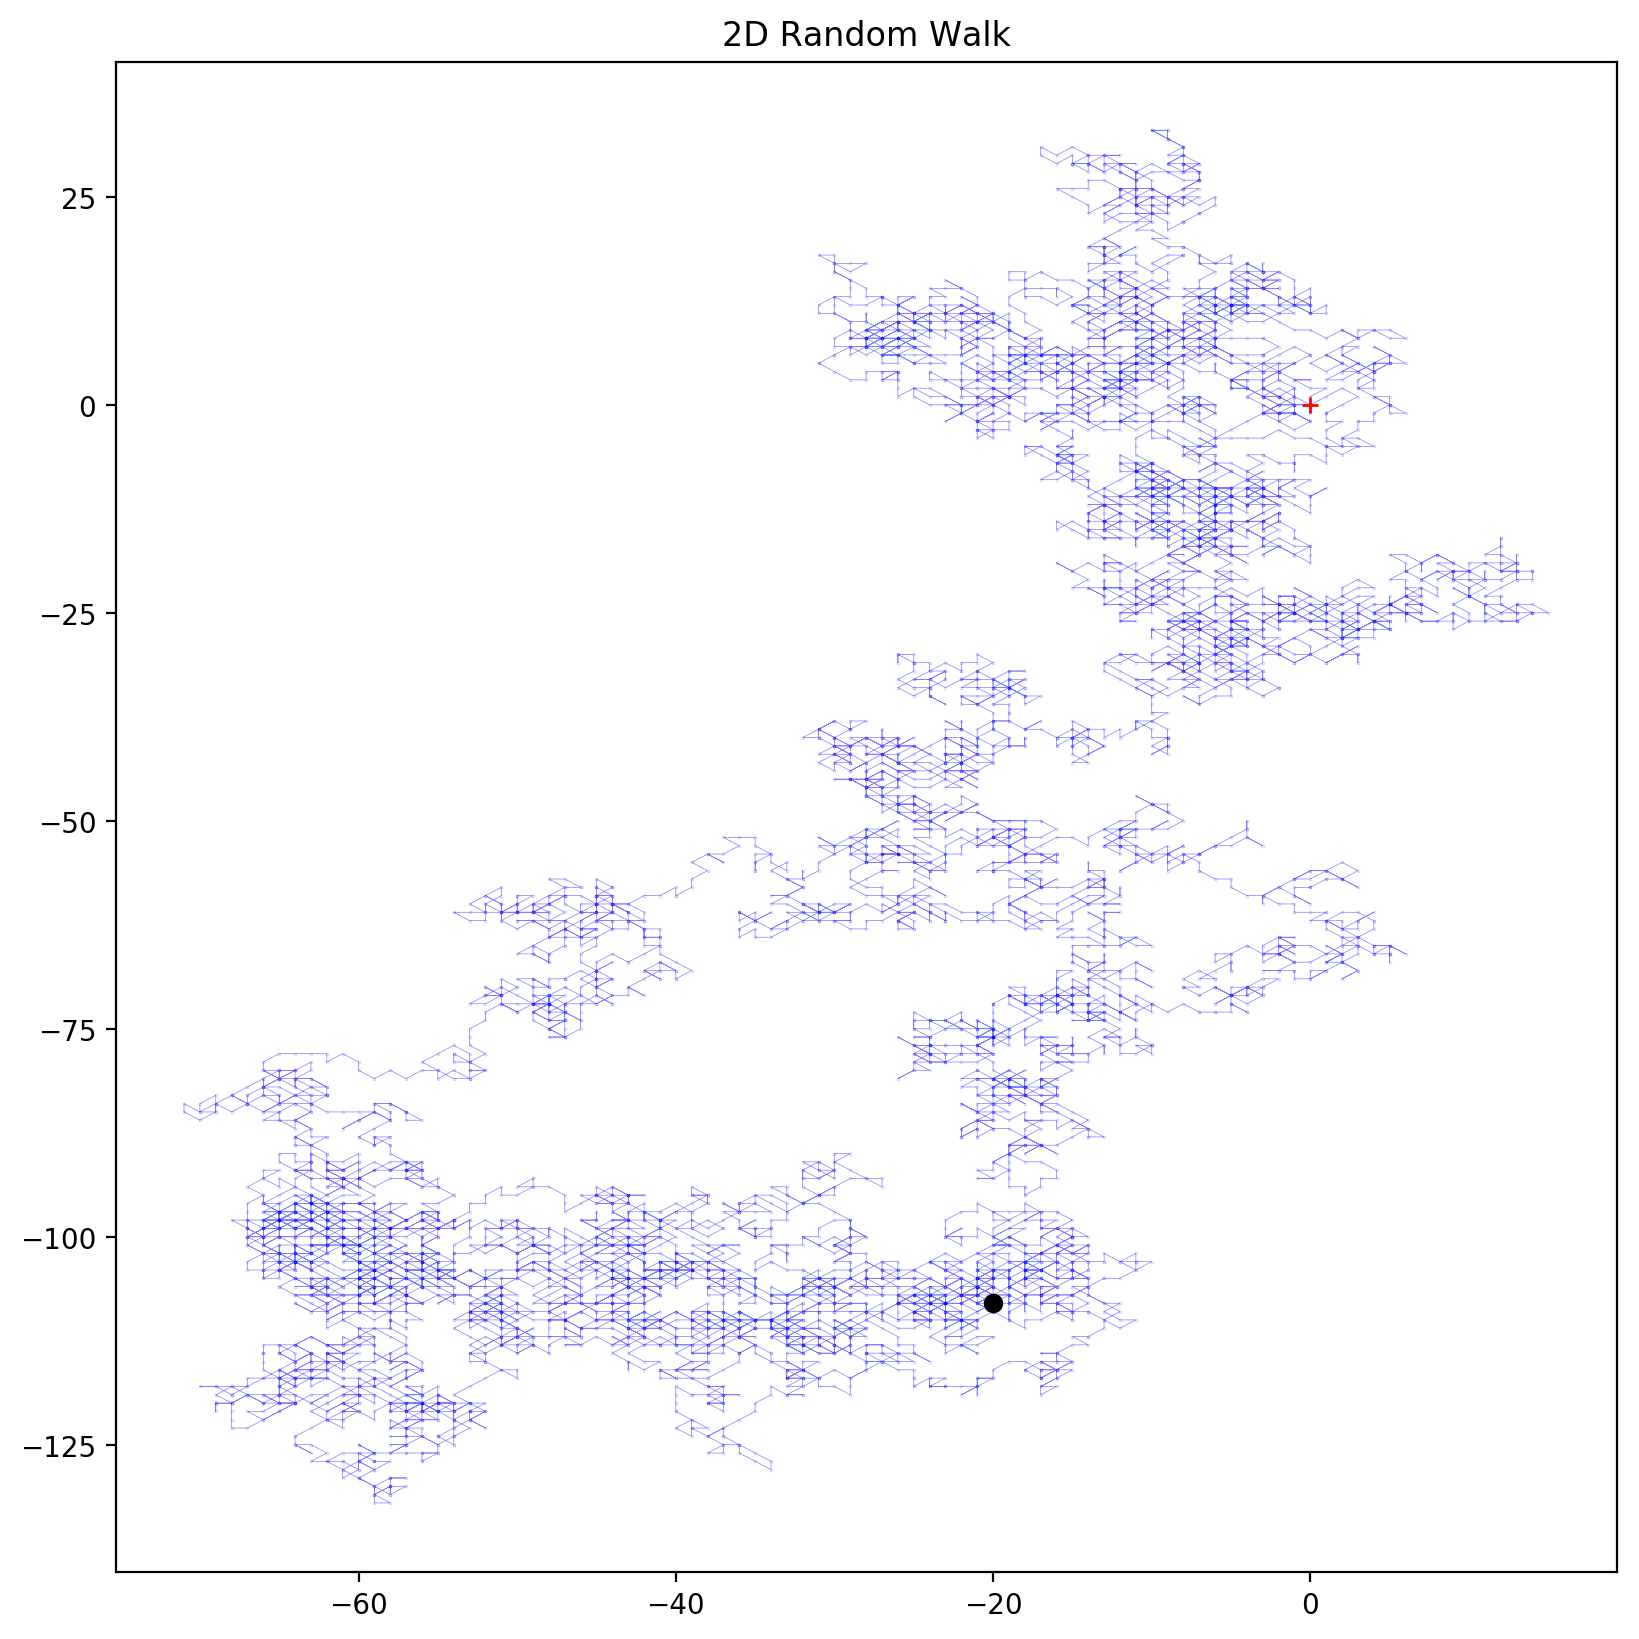

In [31]:
# Define parameters for the walk
dims = 2
step_n = 10000
step_set = [-1, 0, 1]
origin = np.zeros((1,dims))

# Simulate steps in 2D
step_shape = (step_n,dims)
steps = np.random.choice(a=step_set, size=step_shape)
path = np.concatenate([origin, steps]).cumsum(0)
start = path[:1]
stop = path[-1:]

# Plot the path
fig = plt.figure(figsize=(8,8),dpi=200)
ax = fig.add_subplot(111)

ax.scatter(path[:,0], path[:,1],c='blue', alpha=0.25, s=0.05);
ax.plot(path[:,0], path[:,1], c='blue', alpha=0.5, lw=0.25);
ax.plot(start[:,0], start[:,1], c='red', marker='+')
ax.plot(stop[:,0], stop[:,1], c='black', marker='o')

plt.title('2D Random Walk')
plt.tight_layout(pad=0)

#### Example - 3

A random walk is different from a list of random numbers because the next value in the sequence is a modification of the previous value in the sequence.

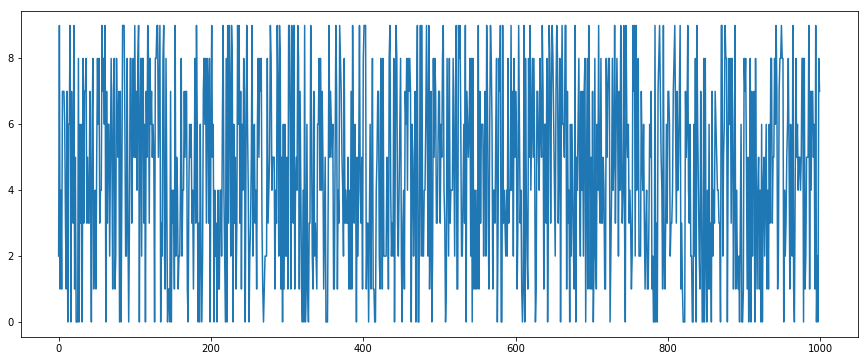

In [33]:
from random import randrange
seed(1)
series = [randrange(10) for i in range(1000)]
plt.plot(series)

** This is not a random walk. It is just a sequence of random numbers. **

A simple model of a random walk is as follows:

    Start with a random number of either -1 or 1.
    
    Randomly select a -1 or 1 and add it to the observation from the previous time step.
    
    Repeat step 2 for as long as you like.
    
y(t) = B0 + B1*X(t-1) + e(t)

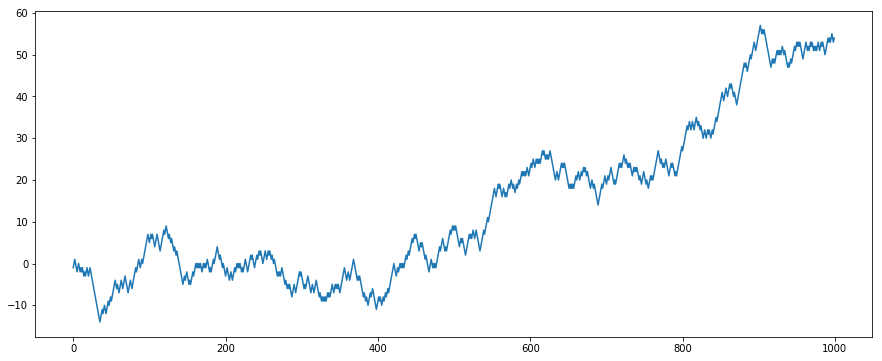

In [35]:
from random import seed
from random import random
seed(1)

random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)

for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
    
plt.plot(random_walk)

We can see that it looks very different from our above sequence of random numbers. In fact, the shape and movement looks like a realistic time series for the price of a security on the stock market.